In [1]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Interactive namespace is empty.


In [2]:
import numpy
import sympy
import scipy
import control
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 })
%matplotlib inline

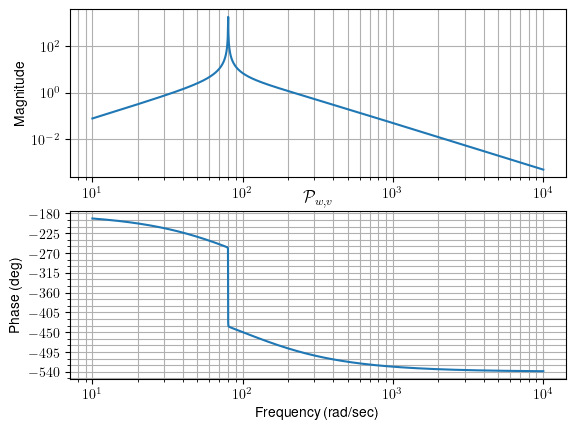

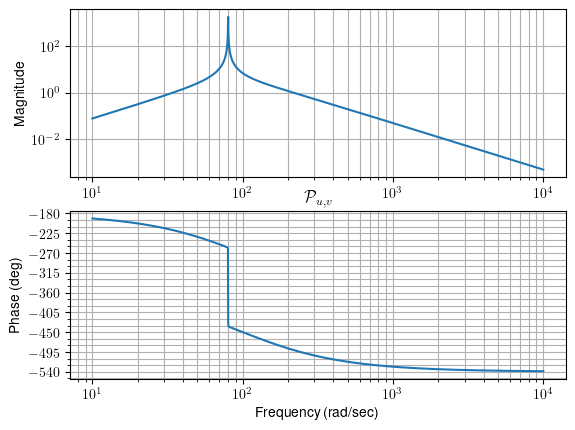

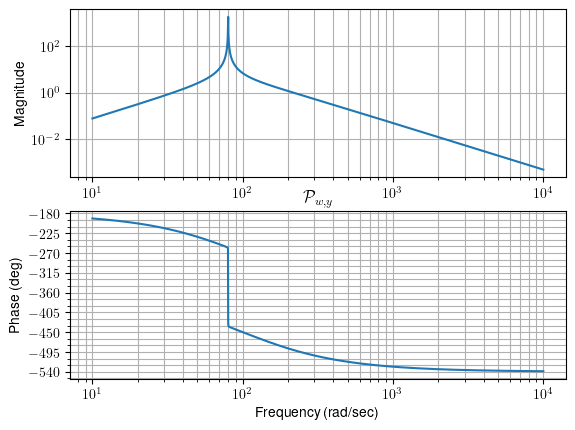

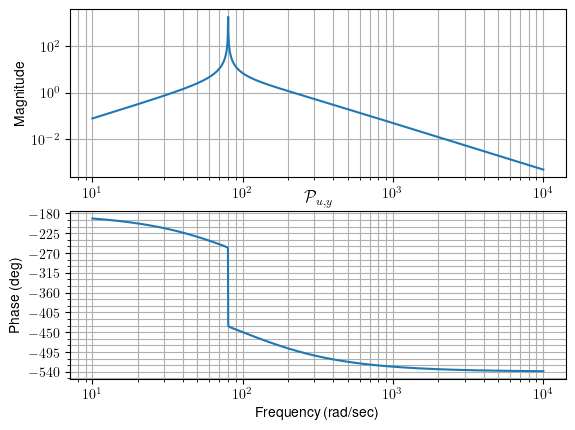

c:\Users\20224091\Documents\GitHub\model_reduction\custom_utils.py:60: RuntimeWarning: invalid value encountered in sqrt
  hsv = numpy.linalg.eigvals(WcBal@WoBal)**(1/2)


In [3]:
# FOM Plant Creation
# plant_zeros = []
# plant_poles = [-0.01+100j, -0.01-100j, -1000]
# plant_gain = 10e6    
# mathcalP = control.zpk(plant_zeros, plant_poles, plant_gain)

num_wv = numpy.array(0.5e5*numpy.poly([1e-3, 1e-4]))
num_wy = numpy.array(0.5e5*numpy.poly([1e-4, 1e-5]))
num_uv = numpy.array(0.5e5*numpy.poly([1e-5, 1e-6]))
num_uy = numpy.array(0.5e5*numpy.poly([1e-6, 1e-7]))
num = numpy.array([numpy.array([num_wv,num_uv]),\
        numpy.array([num_wy,num_uy])])
# print (num.shape)
# print(num)

common_den = numpy.poly([-0.01+80j, -0.01-80j, -100, -100])
den = numpy.array([numpy.array([common_den,common_den]),\
        numpy.array([common_den,common_den])])
# print(den.shape)
# print(den)

mathcalP = control.tf2ss(control.tf(num,den))
# print(mathcalP)

omega_grid = numpy.logspace(1,4,2000)

# Bodes plant
plt.figure()
control.bode(control.ss2tf(mathcalP)[0,0],omega=omega_grid)
plt.title("$\\mathcal{P}_{w,v}$")
plt.show()

plt.figure()
control.bode(control.ss2tf(mathcalP)[0,1],omega=omega_grid)
plt.title("$\\mathcal{P}_{u,v}$")
plt.show()

plt.figure()
control.bode(control.ss2tf(mathcalP)[1,0],omega=omega_grid)
plt.title("$\\mathcal{P}_{w,y}$")
plt.show()

plt.figure()
control.bode(control.ss2tf(mathcalP)[1,1],omega=omega_grid)
plt.title("$\\mathcal{P}_{u,y}$")
plt.show()

# MOR
truncMathcalP, _, _ = ControlUtils.balaced_truncation(mathcalP, 3)


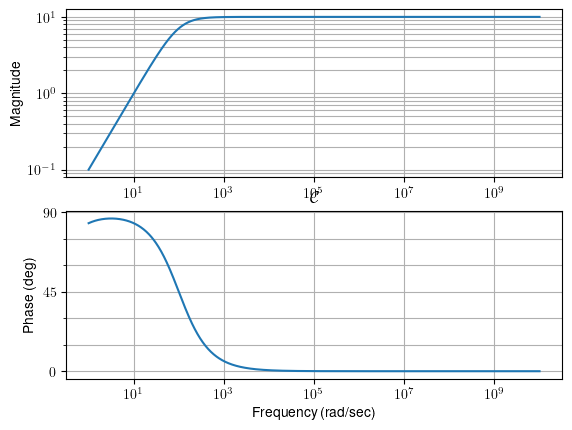

In [4]:
# PD Controller creation
Kp = 100e-4
Td = 10e0
N = 1.0e3
num =  [ Kp*((Td/N)+Td), Kp ]
den = [ (Td/N), 1 ]
T_sam_con = 2*numpy.pi/10e2 # omega = 2*pi/Tsam i.e. sampling time equal to resonance frequency (Very empirical)
mathcalC = control.tf2ss(num,den)
wLims = numpy.array([1e0, 1e10])

# Bode controller
control.bode_plot(mathcalC, omega_limits=wLims, deg=True, wrap_phase=True)
plt.title("$\\mathcal{C}$")
plt.show()

# Controller discretization
overlineMathcalC = control.sample_system(mathcalC, T_sam_con, 'zoh')

In [5]:
# Creating closed-loop

# Controller matrices
Ac = mathcalC.A
Bv = mathcalC.B
Cw = mathcalC.C
Dw = mathcalC.D

#######################################################################

# FOM Plant
Ap = mathcalP.A
Bw = mathcalP.B[:,0:1]
Bu = mathcalP.B[:,1:2]
Cv = mathcalP.C[0:1,:]
Cy = mathcalP.C[-1:,:]
Dv = mathcalP.D[0:1,:]
Dy = mathcalP.D[-1:,:]

# Closed-loop with FOM Plant
Acl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                              numpy.column_stack( [ Bv@Cv, Ac ] )
                            ] )
Bcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                              numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                            ] )
Ccl = numpy.row_stack( [ numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                              # numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                              numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                            ] )
Dcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                              # numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                              numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                            ] )
mathcalPcl = control.ss( Acl, Bcl, Ccl, Dcl )

# L2 gain
normInfClMathcalP = ControlUtils.hinfnorm(mathcalPcl)
display(Math('\\lVert \\mathcal{P}_{ext}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} = ' + str(normInfClMathcalP)))

# Small-gain condition
# display(Math('\\lVert \\mathcal{P}_{ext}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
#     + str(normInfClExtMathcalP*normInfWidetildeMathcalCs) ))

#######################################################################

truncAp = truncMathcalP.A
truncBw = truncMathcalP.B[:,0:1]
truncBu = truncMathcalP.B[:,1:2]
truncCv = truncMathcalP.C[0:1,:]
truncCy = truncMathcalP.C[-1:,:]
truncDv = truncMathcalP.D[0:1,:]
truncDy = truncMathcalP.D[-1:,:]

# Closed-loop with ROM Plant
truncAcl = numpy.row_stack( [ numpy.column_stack( [ truncAp + truncBw@Dw@truncCv, truncBw@Cw ] ),
                              numpy.column_stack( [ Bv@truncCv, Ac ] )
                            ] )
truncBcl = numpy.row_stack( [ numpy.column_stack([truncBw, truncBu]),
                              numpy.column_stack( [ numpy.zeros( (Ac.shape[0],truncBw.shape[1]) ), numpy.zeros( (Ac.shape[0],truncBu.shape[1]) ) ] )
                            ] )
truncCcl = numpy.row_stack( [ numpy.column_stack( [ truncCv, numpy.zeros( (truncCv.shape[0],Ac.shape[0]) ) ] ),
                              # numpy.column_stack( [ truncCv@truncAp + truncCv@truncBw@Dw@truncCv, truncCv@truncBw@Cw ] ),
                              numpy.column_stack( [ truncCy, numpy.zeros( (truncCy.shape[0],Ac.shape[0]) ) ] )
                            ] )
truncDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (truncCv.shape[0],truncBw.shape[1]) ), numpy.zeros( (truncCv.shape[0],truncBu.shape[1]) ) ] ),
                              # numpy.column_stack( [ truncCv@truncBw , truncCv@truncBu] ),
                              numpy.column_stack( [ numpy.zeros( (truncCy.shape[0],truncBw.shape[1]) ), numpy.zeros( (truncCy.shape[0],truncBu.shape[1]) ) ] )
                            ] )
truncMathcalPcl = control.ss(truncAcl,truncBcl,truncCcl,truncDcl)

# L2 gain
normInfTruncMathcalPcl = ControlUtils.hinfnorm(truncMathcalPcl)
display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} = ' + str(normInfTruncMathcalPcl)))

# Small-gain condition
# display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}}\\ {\\small ||_{f}}\\ \\mathcal{C} \\rVert_{\\infty} \\ \\cdot\\ \\lVert \\widetilde{\\mathcal{C}}_{s} \\rVert_{\\infty} = ' \
    # + str(normInfTruncMathcalPcl*normInfWidetildeMathcalCs) ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# Simulation parameters
T_step = 0.0005
t_ini = 0
t_fin = 3
steps = int(numpy.ceil((t_fin-t_ini)/T_step))
T_step = (t_fin-t_ini)/steps

tkVec = numpy.arange(t_ini, t_fin, T_step)[:, None]
tVec = numpy.linspace(t_ini, t_fin, steps)[:, None]
# uVec = 1e-4*numpy.sin(2*numpy.pi*tVec/0.1)
uVec = 1*numpy.sin((2*numpy.pi/T_step)*tVec)
zerosVec = 0*numpy.zeros((steps,1))


In [7]:
xpclVecFOM = ODEUtils.solveLinearSystem(mathcalP, mathcalC,\
                            xp0=0*numpy.random.rand(*(mathcalP.A.shape[0], 1)),
                            xc0=0*numpy.random.rand(*(mathcalC.A.shape[0], 1)),
                            uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step)

The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of

c:\Users\20224091\Documents\GitHub\model_reduction\custom_utils.py:154: RuntimeWarning: overflow encountered in matmul
  return ( (Acl@xcl.reshape(clOrder, 1)) + (Bcl[:,1:2]@uHandler([t])) ).reshape(clOrder,)
c:\Users\20224091\Documents\GitHub\model_reduction\custom_utils.py:154: RuntimeWarning: invalid value encountered in matmul
  return ( (Acl@xcl.reshape(clOrder, 1)) + (Bcl[:,1:2]@uHandler([t])) ).reshape(clOrder,)
c:\Users\20224091\Anaconda3\envs\control_env\lib\site-packages\scipy\integrate\_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


In [8]:
xpclVecROM = ODEUtils.solveLinearSystem(truncMathcalPcl, mathcalC,\
                            xp0=0*numpy.random.rand(*(truncMathcalPcl.A.shape[0], 1)),
                            xc0=0*numpy.random.rand(*(mathcalC.A.shape[0], 1)),
                            uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step)

The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of threshold: 10000000000.0
The norm of the state is out of

: 

In [ ]:
# FOM
# tVecresultFOM = control.input_output_response(mathcalPcl, tVec.squeeze(),numpy.column_stack([zerosVec,uVec]).T,\
                                        # numpy.zeros((mathcalPcl.A.shape[0],1)),t_eval=tVec.squeeze())

In [ ]:
# ROM
# resultROM = control.input_output_response(truncMathcalPcl, tVec.reshape(-1),numpy.column_stack([zerosVec,uVec]).T,\
                                        # numpy.zeros((truncMathcalPcl.A.shape[0],1)),t_eval=tVec.reshape(-1))

In [ ]:
# Sampled FOM
xpVecFOM, xcVecFOM, vsVecFOM, whVecFOM = ODEUtils.solveSDLinearSystem(plant=mathcalP,
                                                          discrete_controller=overlineMathcalC,
                                                          xp0=0*numpy.random.rand(*(mathcalP.A.shape[0], 1)),
                                                          xc0=0*numpy.random.rand(*(overlineMathcalC.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

ValueError: x and y arrays must have at least 2 entries

In [ ]:
# Sampled ROM
xpVecROM, xcVecROM, vsVecROM, whVecROM = ODEUtils.solveSDLinearSystem(plant=truncMathcalP,
                                                          discrete_controller=overlineMathcalC,
                                                          xp0=0*numpy.random.rand(*(truncMathcalP.A.shape[0], 1)),
                                                          xc0=0*numpy.random.rand(*(overlineMathcalC.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

ValueError: x and y arrays must have at least 2 entries

In [ ]:
# Compute outputs
tLims = [t_ini,t_fin]
idxLims = range(numpy.where(tVec[:, 0] >= tLims[0])[0][0], numpy.where(tVec[:, 0] >= tLims[1])[0][0] + 1)

# yVecFOM = resultFOM.outputs[-1][:,None].T 
# vVecFOM = resultFOM.outputs[0][:,None].T
# yVecROM = resultROM.outputs[-1][:,None].T
# vVecROM = resultROM.outputs[0][:,None].T

yVecFOM = mathcalPcl.C[-1:,:] @ xpclVecFOM + mathcalPcl.D[-1:,:] @ uVec
vVecFOM = mathcalPcl.C[0:,:] @ xpclVecFOM + mathcalPcl.D[0:,:] @ uVec

yVecROM = truncMathcalPcl.C[-1:,:] @ xpclVecROM + truncMathcalPcl.D[-1:,:] @ uVec
vVecROM = truncMathcalPcl.C[0:,:] @ xpclVecROM + truncMathcalPcl.D[0:,:] @ uVec

yVecSampledFOM = mathcalP.C[-1:,:] @ xpVecFOM
vVecSampledFOM = mathcalP.C[0:1,:] @ xpVecFOM

yVecSampledROM = truncMathcalP.C[-1:,:] @ xpVecROM
vVecSampledROM = truncMathcalP.C[0:1,:] @ xpVecROM

plt.plot(tVec[idxLims, 0], yVecFOM[0, idxLims], 'k', label="FOM", linestyle='solid')
plt.plot(tVec[idxLims, 0], yVecROM[0, idxLims], 'b', label="ROM", linestyle='solid')
plt.plot(tVec[idxLims, 0], yVecSampledFOM[0, idxLims], 'c', label="Sampled FOM", linestyle='dashed')
plt.plot(tVec[idxLims, 0], yVecSampledROM[0, idxLims], 'r', label="Sampled ROM", linestyle='dashed')
plt.ticklabel_format(axis='y', scilimits=(-3,-3))
plt.title('Plant output $y$')
plt.ylabel('Deflection ($m$)')
plt.xlabel('Time ($s$)')
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_figwidth(6)
plt.show()
        
plt.plot(tVec[idxLims, 0], vVecFOM[0, idxLims], 'k', label="FOM", linestyle='solid')
plt.plot(tVec[idxLims, 0], vVecROM[0, idxLims], 'b', label="ROM", linestyle='solid')
plt.plot(tVec[idxLims, 0], vVecSampledFOM[0, idxLims], 'c', label="Sampled FOM", linestyle='dashed')
plt.plot(tVec[idxLims, 0], vVecSampledROM[0, idxLims], 'r', label="Sampled ROM", linestyle='dashed')
plt.ticklabel_format(axis='y', scilimits=(-3,-3))
plt.title('Plant output $v$')
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_figwidth(6)
plt.show()
